In [2]:
%load_ext autoreload
%autoreload 2

# Setup


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from modules.nlp import NLP
from modules.visualisation import Visualisation

DATA_DIR = Path().cwd() / 'data'
EMBEDDINGS_DIR = Path().cwd() / 'embeddings'

nlp = NLP()
vis = Visualisation(fig_size=(8, 8))

# Load posts
posts_df = pd.read_csv(DATA_DIR / 'reddit_parenting_combined.csv')

# Remove posts with no text
posts_df.dropna(subset='selftext_clean', inplace=True)

# Drop posts from the parenting subreddit
posts_df = posts_df[posts_df['subreddit'] != 'Parenting']

# Text preprocessing *(Depreciated)*

In [ ]:
# Tokenize text and remove stopwords
tqdm.pandas(desc='Tokenizing Reddit text')
posts_df['tokens'] = posts_df['selftext'].progress_apply(
    nlp.tokenize_text)

# Drop empty token cells
posts_df.dropna(subset=['tokens'], inplace=True)

Tokenizing Reddit text: 100%|██████████| 3790/3790 [00:02<00:00, 1518.46it/s]


# Terms in common across all subreddits

In [7]:
# Group texts by subreddit
texts_by_subreddit = {
    subreddit: group['selftext_clean'].tolist()
    for subreddit, group in posts_df.groupby('subreddit')
}

# Generate tf-idf matrices and terms
subreddit_data = {
    subreddit: nlp.generate_tfidf_matrix(texts)
    for subreddit, texts in texts_by_subreddit.items()
}

# Extract vocabularies
vocabularies = [set(terms) for _, terms in subreddit_data.values()]

# Find common terms across all subreddits
common_terms = set.intersection(*vocabularies)

# Create mean tf-idf dataframes for each subreddit
tfidf_dfs = []
for subreddit, (tfidf_matrix, terms) in subreddit_data.items():
    mean_tfidf_matrix = tfidf_matrix.mean(axis=0)
    mean_tfidf_df = pd.DataFrame(
        mean_tfidf_matrix.T,
        index=terms,
        columns=[subreddit]
    ).loc[list(common_terms)]
    tfidf_dfs.append(mean_tfidf_df)

# Concatenate mean tf-idf dataframes
common_terms_df = pd.concat(tfidf_dfs, axis=1)

# Calculate an average tf-idf score for each term
common_terms_df['mean_tfidf'] = common_terms_df.mean(axis=1)

# Sort terms by average tf-idf score
common_terms_df.sort_values('mean_tfidf', ascending=False, inplace=True)
common_terms_df.head(10)

,CatholicParenting,MuslimParenting,atheistparents,mean_tfidf
im,0.026920,0.036058,0.037993,0.033657
kids,0.022714,0.036440,0.034862,0.031339
like,0.024644,0.028630,0.031406,0.028226
dont,0.018808,0.026139,0.037199,0.027382
would,0.020496,0.025963,0.030909,0.025789
want,0.021281,0.024940,0.030526,0.025582
children,0.025711,0.027782,0.021019,0.024837
know,0.022860,0.021576,0.025214,0.023217
parents,0.014446,0.028896,0.023193,0.022178
one,0.024822,0.018445,0.021826,0.021698


## Plotting word similarities using t-SNE

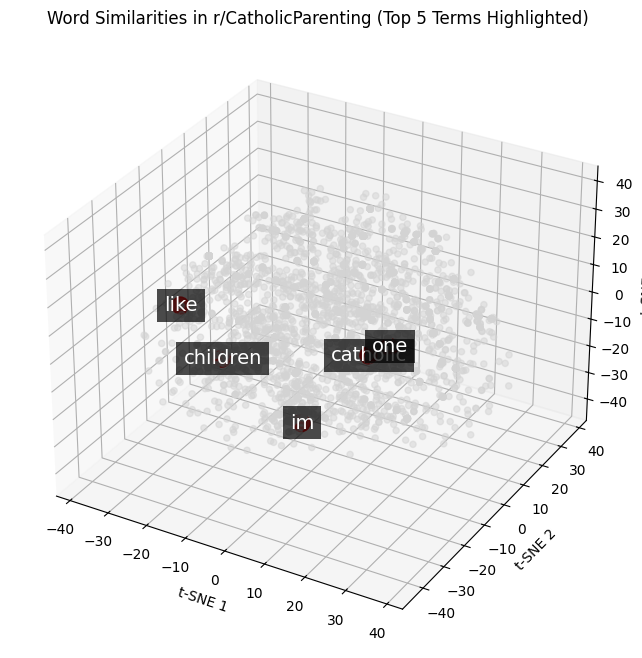

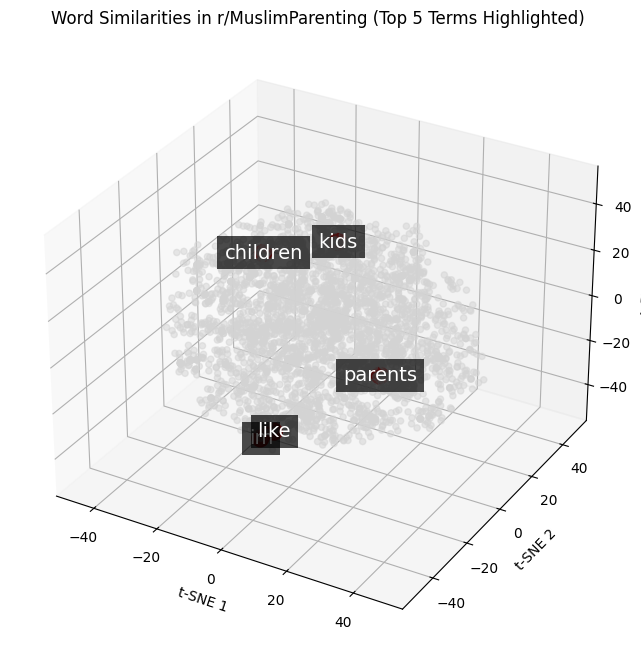

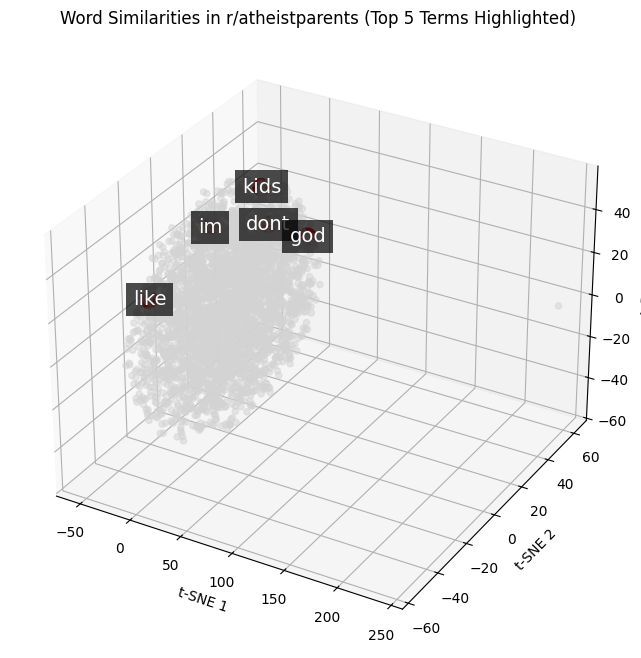

In [106]:
for subreddit, (tfidf_matrix, terms) in subreddit_data.items():
    vis.plot_word_similarities_tsne_3d(
        tfidf_matrix=tfidf_matrix,
        feature_names=terms,
        subreddit=f'r/{subreddit}'
    )

plt.show()

# Embeddings


**Pretrained embeddings:** Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. Download from [this link](https://nlp.stanford.edu/data/glove.840B.300d.zip).


In [107]:
word_vectors = KeyedVectors.load_word2vec_format(
    EMBEDDINGS_DIR / 'glove.840B.300d.txt', binary=False, no_header=True)

In [ ]:
# Generate tf-idf matrix
tfidf_matrix, terms = nlp.generate_tfidf_matrix(
    posts_df['selftext_clean'].values.tolist())

# Generate word embeddings
word_embeddings = nlp.generate_tfidf_weighted_embeddings(
    tokens=posts_df['selftext_clean'].values.tolist(),
    feature_names=terms,
    tfidf_matrix=tfidf_matrix,
    word_vectors=word_vectors)
posts_df['embeddings'] = word_embeddings.tolist()

# Save DataFrame for later use
posts_df.to_csv(
    DATA_DIR / 'reddit_parenting_combined_embeddings.feather', index=False)

## Plotting embeddings using t-SNE

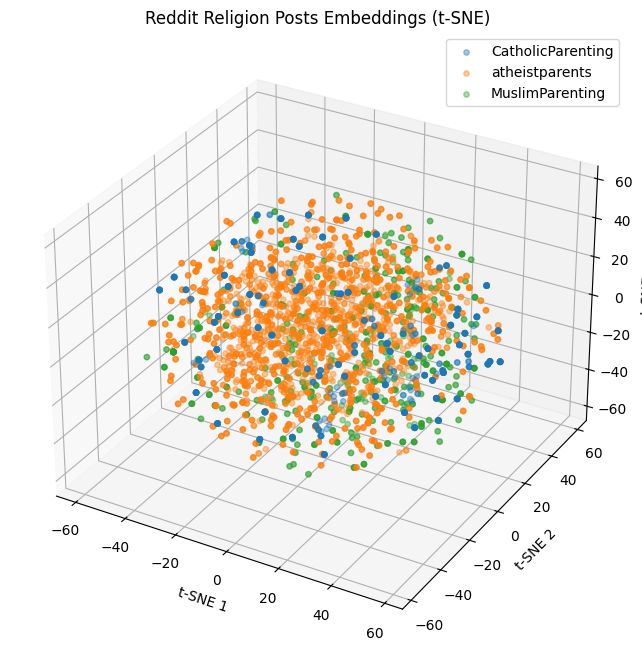

In [109]:
# Plot t-SNE of word embeddings
vis.plot_tsne_3d(
    embeddings=np.vstack(posts_df['embeddings'].values),
    posts_df=posts_df,
    title='Reddit Religion Posts Embeddings (t-SNE)',
)

plt.show()

## Calculating cosine similarities

In [110]:
# Calculate a centroid for each subreddit
centroid_matrix = nlp.calculate_centroids(
    posts_df=posts_df,
    embeddings_column='embeddings'
)

# Calculate cosine similarities between centroids
similarities = cosine_similarity(centroid_matrix)
subreddit_similarity_df = pd.DataFrame(
    similarities, index=posts_df['subreddit'].unique(),
    columns=posts_df['subreddit'].unique())

# Get unique subreddit pairs and their similarities
pairs = []
for i, sub1 in enumerate(subreddit_similarity_df.index):
    for j, sub2 in enumerate(subreddit_similarity_df.columns):
        # Skip self-comparisons and duplicate pairs
        if i < j:
            similarity = subreddit_similarity_df.loc[sub1, sub2]
            pairs.append({
                'subreddit1': sub1,
                'subreddit2': sub2,
                'similarity': similarity
            })

# Convert to DataFrame and sort by similarity
pairs_df = pd.DataFrame(pairs)
pairs_df = pairs_df.sort_values('similarity', ascending=False)
pairs_df

,subreddit1,subreddit2,similarity
1,CatholicParenting,MuslimParenting,0.988339
2,atheistparents,MuslimParenting,0.986657
0,CatholicParenting,atheistparents,0.983038


## Plotting vector representations of embeddings

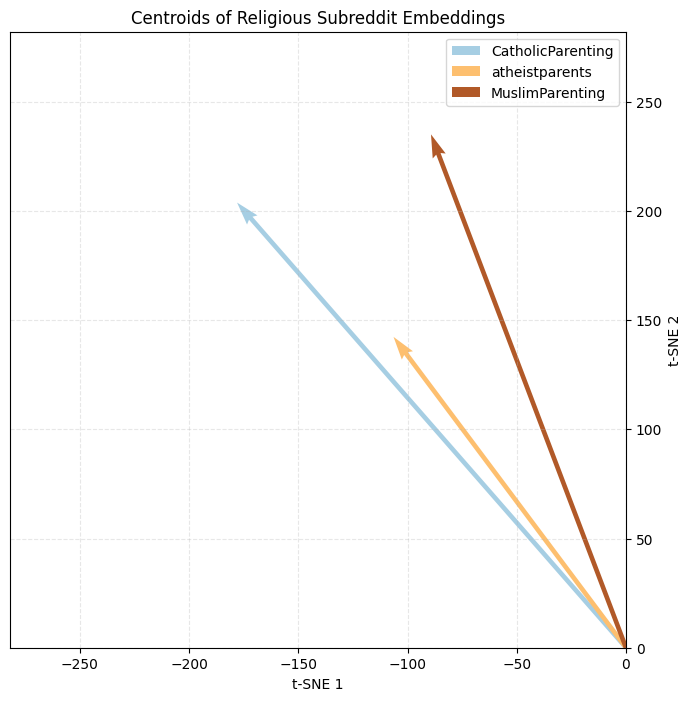

In [111]:
vis.plot_subreddit_vector_space(posts_df=posts_df,
                                embeddings_column='embeddings',
                                title='Centroids of Religious Subreddit Embeddings',
                                labels=posts_df['subreddit'].unique())

plt.show()